# Autonomous Systems Perception and Situation Understanding – Project

## 1. Point Projection and Coordinate Transformation

**Authors:** Lukas Gerstlauer, Jakob Kurz  
**Semester:** Summer 2025

---

### Overview

This notebook demonstrates the projection of 2D image points to 3D world coordinates using stereo vision and camera calibration parameters. The workflow includes loading stereo images, selecting corresponding pixels, computing disparity, and transforming the reconstructed 3D points into the world coordinate system. Validation is performed using an object of known size.

### Import Libraries

In [ ]:
import cv2
import numpy as np
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

### Load and display stereo images
This section loads the left and right stereo images and displays them side by side for visualization.

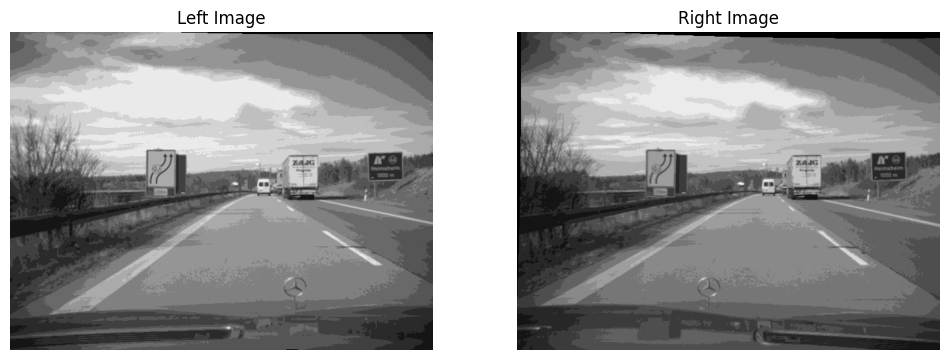

In [295]:
notebook_dir = os.getcwd()
image_left_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteLeft', 'image0110_c0.pgm')
image_right_path = os.path.join(notebook_dir, 'Additional_files', 'Stereo_images', 'ConstructionSiteRight', 'image0110_c1.pgm')

image_left = cv2.imread(image_left_path, cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread(image_right_path, cv2.IMREAD_GRAYSCALE)

image_left_display = cv2.normalize(image_left, None, 0, 255, cv2.NORM_MINMAX)
image_right_display = cv2.normalize(image_right, None, 0, 255, cv2.NORM_MINMAX)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image_left_display, cmap='gray')
axs[0].set_title('Left Image')
axs[0].axis('off')
axs[1].imshow(image_right_display, cmap='gray')
axs[1].set_title('Right Image')
axs[1].axis('off')
plt.show()

### Select pixels for 3D reconstruction
This function allows you to select corresponding pixels in both images using the mouse. These pixels are used to calculate disparity and reconstruct the 3D coordinates.

In [296]:
def get_pixel_by_images(num_pixels=1):
    pixel_left = None
    pixel_right = None
    pixel_left2 = None
    pixel_right2 = None

    def mouse_callback(event, x, y, flags, param):
        nonlocal pixel_left, pixel_right, pixel_left2, pixel_right2
        if event == cv2.EVENT_LBUTTONDOWN:
            img, name = param
            print(f"{name}: Click at ({x}, {y})")
            if name == 'Left Image':
                if pixel_left is None:
                    pixel_left = [x, y]
                elif pixel_left2 is None:
                    pixel_left2 = [x, y]
            elif name == 'Right Image':
                if pixel_right is None:
                    pixel_right = [x, y]
                elif pixel_right2 is None:
                    pixel_right2 = [x, y]

    cv2.namedWindow('Left Image')
    cv2.setMouseCallback('Left Image', mouse_callback, param=(image_left, 'Left Image'))
    cv2.namedWindow('Right Image')
    cv2.setMouseCallback('Right Image', mouse_callback, param=(image_right, 'Right Image'))

    cv2.imshow('Left Image', image_left_display)
    cv2.imshow('Right Image', image_right_display)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if num_pixels == 2:
        return pixel_left, pixel_right, pixel_left2, pixel_right2
    else:
        return pixel_left, pixel_right

### Choose pixel selection method
You can either use the mouse to select pixels or use predefined pixel coordinates.

In [297]:
USE_MOUSE = False  

if USE_MOUSE:
    pixel_left, pixel_right = get_pixel_by_images()
else:
    pixel_left = [250, 250]
    pixel_right = [238, 250]

print("Pixel left image:", pixel_left)
print("Pixel right image:", pixel_right)

Pixel left image: [250, 250]
Pixel right image: [238, 250]


### Solution
This section contains the steps to compute the 3D coordinates of a point in the world coordinate system, starting from pixel selection in stereo images.

#### Calculate disparity
The disparity is the difference in x-coordinates between the left and right image pixels.

In [298]:
def calc_disparity(pixel_left, pixel_right):
    # Disparity is the difference in x-coordinates
    return pixel_left[0] - pixel_right[0]

In [299]:
disparity = calc_disparity(pixel_left, pixel_right)

print("Disparity:", disparity)

Disparity: 12


#### Read camera parameters from file
This section reads the internal and external camera parameters from a configuration file. These parameters are essential for calculating the camera matrix, rotation matrix, and translation vector.

In [300]:
camera_txt_path = os.path.join(notebook_dir, 'Additional_files', 'Camera.txt')
with open(camera_txt_path, 'r') as f:
    camera_txt_content = f.read()

internal_params = {}
external_params = {}

section = None
for line in camera_txt_content.strip().split('\n'):
    line = line.strip()
    if line == '[INTERNAL]':
        section = 'internal'
    elif line == '[EXTERNAL]':
        section = 'external'
    elif '=' in line and section:
        key, value = line.split('=', 1)
        value_clean = value.split('#', 1)[0].strip()
        try:
            value_num = float(value_clean)
        except ValueError:
            value_num = value_clean  
        if section == 'internal':
            internal_params[key.strip()] = value_num
        elif section == 'external':
            external_params[key.strip()] = value_num

print("Internal parameters:", internal_params)
print("External parameters:", external_params)

Internal parameters: {'F': 820.428, 'SX': 1.0, 'SY': 1.000283, 'X0': 305.278, 'Y0': 239.826}
External parameters: {'B': 0.308084, 'LATPOS': -0.07, 'HEIGHT': 1.26, 'DISTANCE': 2.0, 'TILT': 0.06, 'YAW': 0.01, 'ROLL': 0.0}


#### Compute camera matrix
The camera matrix K is calculated using the internal parameters.

In [301]:
K = np.array([
    [internal_params['F'] / internal_params['SX'], 0, internal_params['X0']],
    [0, internal_params['F'] / internal_params['SY'], internal_params['Y0']],
    [0, 0, 1]
])
K_inv = np.linalg.inv(K)
print("Camera matrix K:\n", K)

Camera matrix K:
 [[820.428        0.         305.278     ]
 [  0.         820.19588456 239.826     ]
 [  0.           0.           1.        ]]


#### Compute rotation matrix
The rotation matrix is derived from the external parameters (roll, pitch, yaw).

In [302]:
roll = external_params['ROLL']    
pitch = external_params['TILT']   
yaw = external_params['YAW']      

# Create rotation matrix from Euler angles
r = R.from_euler('zyx', [yaw, pitch, roll], degrees=False)

R_wc = r.as_matrix()
print("Rotation matrix R_wc:\n", R_wc)
R_cw = R_wc.T
print("Rotation matrix R_cw:\n", R_cw)

Rotation matrix R_wc:
 [[ 9.98150630e-01 -9.98183903e-03  5.99640065e-02]
 [ 9.99983333e-03  9.99950000e-01  0.00000000e+00]
 [-5.99610083e-02  5.99630071e-04  9.98200540e-01]]
Rotation matrix R_cw:
 [[ 9.98150630e-01  9.99983333e-03 -5.99610083e-02]
 [-9.98183903e-03  9.99950000e-01  5.99630071e-04]
 [ 5.99640065e-02  0.00000000e+00  9.98200540e-01]]


#### Compute translation vector
The translation vector describes the camera's position in the world coordinate system.

In [303]:
t_wc_din = np.array([
    [external_params['DISTANCE']],   
    [external_params['LATPOS']],
    [external_params['HEIGHT']]      
])

print("Translation vector t_wc_din:\n", t_wc_din)
t_cw_din = -t_wc_din

print("Translation vector t_cw_din:\n", t_cw_din)

Translation vector t_wc_din:
 [[ 2.  ]
 [-0.07]
 [ 1.26]]
Translation vector t_cw_din:
 [[-2.  ]
 [ 0.07]
 [-1.26]]


#### Calculate 3D coordinates in camera system
This function converts pixel coordinates to 3D coordinates in the camera coordinate system.

In [304]:
def pixel_to_coordinate(pixel, internal_params, external_params, disparity):
    # Calculate depth (z) using focal length, baseline, and disparity
    z = (internal_params['F'] * external_params['B']) / disparity
    # Calculate x and y in camera coordinates
    x = ((pixel[0] - internal_params['X0']) * z) / internal_params['F'] / internal_params['SX']
    y = ((pixel[1] - internal_params['Y0']) * z) / internal_params['F'] / internal_params['SY']
    
    return np.array([x, y, z])

In [305]:
p_c = pixel_to_coordinate(pixel_left, internal_params, external_params, disparity)
print("3D point in camera coordinates (P_c):\n", p_c)

3D point in camera coordinates (P_c):
 [-1.41918895  0.26112998 21.063395  ]


#### Convert camera coordinates to DIN (world) coordinates
This function transforms the 3D point from the camera to the DIN coordinate system.

In [306]:
def camera_to_din(p_c):
    # Convert camera coordinates to DIN coordinates
    return np.array([[p_c[2]], [-p_c[0]], [-p_c[1]]])

In [307]:
p_c_din = camera_to_din(p_c) 
print("3D point in DIN coordinates (P_c_din):\n", p_c_din)

3D point in DIN coordinates (P_c_din):
 [[21.063395  ]
 [ 1.41918895]
 [-0.26112998]]


#### Apply rotation and translation to get world coordinates
This function applies the rotation and translation to transform the point into the world coordinate system.

In [308]:
def camera_to_world(p_c, R_cw, t_cw_din):
    # Transform point from camera to world coordinates
    p_w = R_cw @ (p_c - t_cw_din)
    return p_w

In [309]:
p_w_din = camera_to_world(p_c_din, R_cw, t_cw_din)
print("3D point in world (DIN) coordinates (P_w_din):\n", p_w_din)

3D point in world (DIN) coordinates (P_w_din):
 [[22.97434066]
 [ 1.11950534]
 [ 2.38004616]]


### Validation

#### Validation with object of known size
We validate the 3D reconstruction by measuring the distance between two points on a known object (e.g., a traffic sign) in the scene. The real-world dimensions of the object are compared with the computed distances to assess the accuracy of the stereo reconstruction and coordinate transformation.

In [310]:
def pixel_to_world(pixel_left, pixel_right, internal_params, external_params):
    # Full pipeline: pixel to world coordinates
    disparity = calc_disparity(pixel_left, pixel_right)
    p_c = pixel_to_coordinate(pixel_left, internal_params, external_params, disparity)
    p_c_din = camera_to_din(p_c)
    p_w_din = camera_to_world(p_c_din, R_cw, t_cw_din)
    return p_w_din

In [311]:
USE_MOUSE = False  # Set to True to use mouse for pixel selection

if USE_MOUSE:
    get_pixel_by_images(2)
else:
    pixel_left1 = [250, 184]
    pixel_right1 = [238, 184]
    pixel_left2 = [208, 233]
    pixel_right2 = [196, 233]

p_w_din_ref = pixel_to_world(pixel_left, pixel_right, internal_params, external_params)
p1_val_w_din = pixel_to_world(pixel_left1, pixel_right1, internal_params, external_params)
p2_val_w_din = pixel_to_world(pixel_left2, pixel_right2, internal_params, external_params)
print("Reference point (bottom right):\n", p_w_din_ref)
print("Validation point 1 (top right):\n", p1_val_w_din)
print("Validation point 2 (bottom left):\n", p2_val_w_din)

# Distance between reference and validation point 1 (should be sign height)
distance1 = np.linalg.norm(p_w_din_ref - p1_val_w_din)
print("Distance between reference and validation point 1 (height):", f"{distance1:.3f} m")
print("Expected height: 1.600 m")

# Distance between reference and validation point 2 (should be sign width)
distance2 = np.linalg.norm(p_w_din_ref - p2_val_w_din)
print("Distance between reference and validation point 2 (width):", f"{distance2:.3f} m")
print("Expected width: 1.250 m")


Reference point (bottom right):
 [[22.97434066]
 [ 1.11950534]
 [ 2.38004616]]
Validation point 1 (top right):
 [[22.87276776]
 [ 1.12052111]
 [ 4.0709805 ]]
Validation point 2 (bottom left):
 [[22.95896071]
 [ 2.19800706]
 [ 2.81558985]]
Distance between reference and validation point 1 (height): 1.694 m
Expected height: 1.600 m
Distance between reference and validation point 2 (width): 1.163 m
Expected width: 1.250 m


#### Backward calculation: World to image coordinates
This section demonstrates the inverse transformation: projecting a 3D world point back to image coordinates. This is useful for validating the consistency of the transformation pipeline.

In [312]:
p_w_din = np.append(p_w_din, 1)
print("World point (P_w_din) in homogeneous coordinates:\n", p_w_din)

World point (P_w_din) in homogeneous coordinates:
 [22.97434066  1.11950534  2.38004616  1.        ]


In [313]:
Rt_wc = np.hstack((R_wc, -t_wc_din))

p_c_din = Rt_wc @ p_w_din.T

p_c = np.array([-p_c_din[1], -p_c_din[2], p_c_din[0]])
print("3D point in camera coordinates:", p_c)

3D point in camera coordinates: [-1.41918895  0.26112998 21.063395  ]


In [314]:
p_c = np.dot(K, p_c)

pixel_c = np.array([int(p_c[0] / p_c[2]), int(p_c[1] / p_c[2])])

print("Pixel in image coordinates:", pixel_c)
print("Original pixel:", pixel_left)

Pixel in image coordinates: [250 249]
Original pixel: [250, 250]


---
### Summary

In this notebook, we demonstrated the full pipeline from pixel selection in stereo images to 3D reconstruction and transformation into world coordinates. The results were validated using a real-world object of known dimensions, confirming the accuracy of the approach. Additionally, we showcased the backward calculation to project world coordinates back to image coordinates, ensuring the consistency of the transformations. This forms the basis for further perception tasks in autonomous systems.